In [17]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn
from sklearn.neural_network import MLPClassifier
from utils import DataUtils
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from utils import DataUtils
from CS7140_balancers import BinaryBalancer
from sklearn.metrics import confusion_matrix

## Load data and train the MLP classifier

In [18]:
df_train, df_test = DataUtils.load_adults(use_torch_dataset=False, test=0.25)


hidden_layer_sizes = (128)
model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                      learning_rate_init=.003, 
                      verbose=True, 
                      learning_rate="adaptive", 
                      max_iter=300)


trained_model = model.fit(X=df_train.loc[:, df_train.columns != "output"], 
                          y=df_train["output"])

Iteration 1, loss = 0.38681710
Iteration 2, loss = 0.33979197
Iteration 3, loss = 0.32917030
Iteration 4, loss = 0.32249582
Iteration 5, loss = 0.31864759
Iteration 6, loss = 0.31220620
Iteration 7, loss = 0.31005752
Iteration 8, loss = 0.31085277
Iteration 9, loss = 0.30565017
Iteration 10, loss = 0.30337328
Iteration 11, loss = 0.30158713
Iteration 12, loss = 0.29813698
Iteration 13, loss = 0.29684172
Iteration 14, loss = 0.29420960
Iteration 15, loss = 0.29355977
Iteration 16, loss = 0.29266364
Iteration 17, loss = 0.28975896
Iteration 18, loss = 0.28837525
Iteration 19, loss = 0.28580328
Iteration 20, loss = 0.28446712
Iteration 21, loss = 0.28525606
Iteration 22, loss = 0.28196764
Iteration 23, loss = 0.28190803
Iteration 24, loss = 0.27804795
Iteration 25, loss = 0.27840445
Iteration 26, loss = 0.27619586
Iteration 27, loss = 0.27550061


/Users/johnabascal/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### Choose Sensitive Attribute and Report Overall Accuracies

In [3]:
categories = ["native-country", "race", "sex", "workclass"]
targets = ["Mexico", "Black", "Female", "Private"]

Y_accs = []
Y_adj_accs = []
for attribute in zip(categories, targets):
    
    category = attribute[0]
    sensitive_attribute = attribute[1]
    
    
    
    frequency = sum(df_train[category + "_ " + sensitive_attribute])/len(df_train)
    print(f"People with {category}={sensitive_attribute} account for {frequency*100:.4}% of the training data")
    a = np.array(df_test[category + "_ " + sensitive_attribute])

    y_pred =  trained_model.predict(df_test.loc[:, df_train.columns != "output"])
    y_true = np.array(df_test["output"])
    acc = sum(y_pred == y_true)/len(y_pred)
    print(f"The model's overall accuracy is {acc*100:.4}%")
    Y_accs.append(acc)
    
    # Fit balancer to adjust the predictions
    pb = BinaryBalancer(y=y_true, y_=y_pred, a=a, summary=False)
    pb.adjust(goal='odds', summary=False)
    fair_acc = sum(pb.get_adjusted_predictions() == y_true)/len(y_true)
    print(f"The model's overall accuracy after adjustment is {fair_acc*100:.4}%\n")
    Y_adj_accs.append(fair_acc)

People with native-country=Mexico account for 2.019% of the training data
The model's overall accuracy is 83.34%
The model's overall accuracy after adjustment is 79.46%

People with race=Black account for 9.558% of the training data
The model's overall accuracy is 83.34%
The model's overall accuracy after adjustment is 83.05%

People with sex=Female account for 33.16% of the training data
The model's overall accuracy is 83.34%
The model's overall accuracy after adjustment is 81.39%

People with workclass=Private account for 69.75% of the training data
The model's overall accuracy is 83.34%
The model's overall accuracy after adjustment is 80.26%



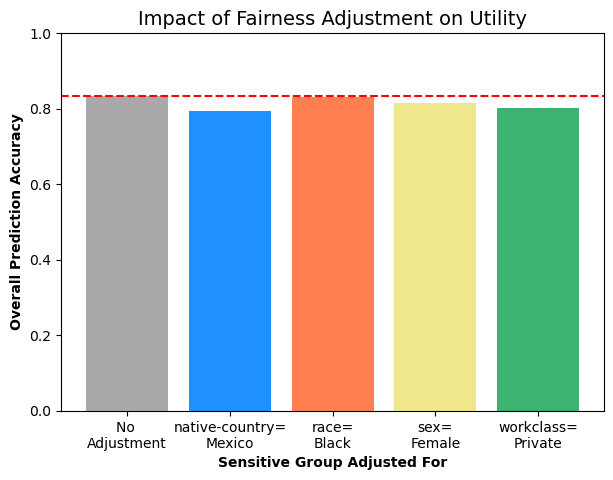

In [16]:
x = np.arange(len(categories) + 1)
width = 0.4
label_font = {
    'color':  'k',
    'weight': 'heavy',
    'size': 10
}

title_font = {
    'color':  'k',
    'size': 14
}

attributes = ["No \nAdjustment"] + [categories[i] + "=\n" + targets[i] for i in range(len(categories))]
plt.figure(figsize=(7,5), dpi=100)
plt.title("Impact of Fairness Adjustment on Utility", fontdict=title_font)
plt.bar(x, [Y_accs[0]] + Y_adj_accs, color=["darkgrey", "dodgerblue", "coral", "khaki", "mediumseagreen"])

plt.xticks(x, attributes)
plt.xlabel("Sensitive Group Adjusted For", fontdict=label_font)
plt.ylabel("Overall Prediction Accuracy", fontdict=label_font)


plt.ylim(0,1)
ax = plt.gca()
ax.autoscale(False)
ax.plot(plt.gca().get_xlim(), [Y_accs[0], Y_accs[0]], c="r", linestyle="--")
plt.draw()

#plt.savefig("Figures/overall_accuracies.jpg")

### Choose Sensitive Attribute and Report Per-Subgroup Accuracies

In [11]:
Y_accs_on_group = []
Y_adj_accs_on_group = []
proportion_of_dataset = []
for attribute in zip(categories, targets):
    
    category = attribute[0]
    sensitive_attribute = attribute[1]
    frequency = sum(df_train[category + "_ " + sensitive_attribute])/len(df_train)
    proportion_of_dataset.append(frequency)
    print(f"People with {category}={sensitive_attribute} account for {frequency*100:.4}% of the training data")
    a = np.array(df_test[category + "_ " + sensitive_attribute])

    y_pred =  trained_model.predict(df_test.loc[:, df_train.columns != "output"])
    y_true = np.array(df_test["output"])
    
    a_bool = a.astype(bool)

    group_acc = sum(y_pred[a_bool] == y_true[a_bool])/len(y_pred[a_bool])
    print(f"The model's loss on this group (0) is {1 - group_acc:.4}")
    Y_accs_on_group.append(group_acc)
    # Fit balancer to adjust the predictions
#     print("Before Adjustment\n", confusion_matrix(y_true[a_bool], y_pred[a_bool]), "\n-----")
    pb = BinaryBalancer(y=y_true, y_=y_pred, a=a, summary=False)
    pb.adjust(goal='odds', summary=False)
    y_adj = pb.get_adjusted_predictions()
    fair_group_acc = sum(y_adj[a_bool] == y_true[a_bool])/len(y_true[a_bool])
    Y_adj_accs_on_group.append(fair_group_acc)
#     print("After Adjustment\n", confusion_matrix(y_true[a_bool], y_adj[a_bool]), "\n-------")
    print(f"The model's loss on this group (0) after adjustment is {1 - fair_group_acc:.4}\n")

People with native-country=Mexico account for 2.019% of the training data
The model's loss on this group (0) is 0.07333
The model's loss on this group (0) after adjustment is 0.08667

People with race=Black account for 9.558% of the training data
The model's loss on this group (0) is 0.1013
The model's loss on this group (0) after adjustment is 0.1392

People with sex=Female account for 33.16% of the training data
The model's loss on this group (0) is 0.08754
The model's loss on this group (0) after adjustment is 0.147

People with workclass=Private account for 69.75% of the training data
The model's loss on this group (0) is 0.1505
The model's loss on this group (0) after adjustment is 0.1906



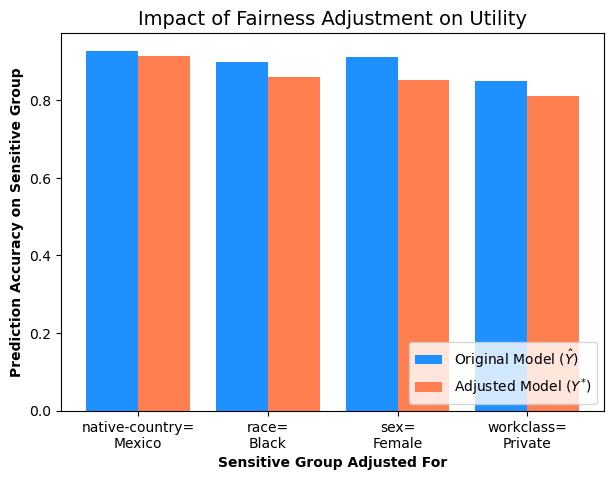

In [12]:

x = np.arange(len(categories))
width = 0.4
label_font = {
    'color':  'k',
    'weight': 'heavy',
    'size': 10
}

title_font = {
    'color':  'k',
    'size': 14
}

attributes =[categories[i] + "=\n" + targets[i] for i in range(len(categories))]
plt.figure(figsize=(7,5), dpi=100)
plt.title("Impact of Fairness Adjustment on Utility", fontdict=title_font)
plt.bar(x - width,  Y_accs_on_group, width = width, color="dodgerblue")
plt.bar(x, Y_adj_accs_on_group, width = width, color="coral")

plt.xticks(x - width/2, attributes)
plt.xlabel("Sensitive Group Adjusted For", fontdict=label_font)
plt.ylabel("Prediction Accuracy on Sensitive Group", fontdict=label_font)
plt.legend(["Original Model ($\hat{Y}$)", "Adjusted Model ($Y^{*}$)"], loc="lower right")
plt.savefig("Figures/subgroup_acuracy.jpg")

## Report Calibration Statistics before and after adjustment

People with native-country=Mexico account for 2.019% of the training data

Calibration: 

                              0         1
Fraction where Y_ = 1  0.211400  0.046700
Fraction where Y* = 1  0.112800  0.060000
Fraction where Y = 1   0.247779  0.066667



Loss: 

           0         1   overall
Y_  0.168314  0.073333  0.166564
Y*  0.205356  0.086667  0.203169




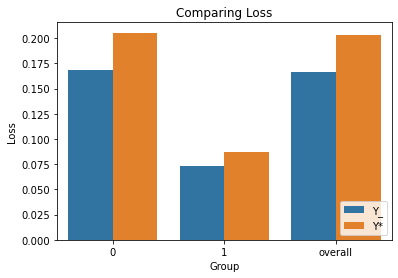

People with race=Black account for 9.558% of the training data

Calibration: 

                              0         1
Fraction where Y_ = 1  0.216300  0.134200
Fraction where Y* = 1  0.216300  0.154400
Fraction where Y = 1   0.256292  0.134177



Loss: 

           0         1   overall
Y_  0.173582  0.101266  0.166564
Y*  0.173582  0.134177  0.169758




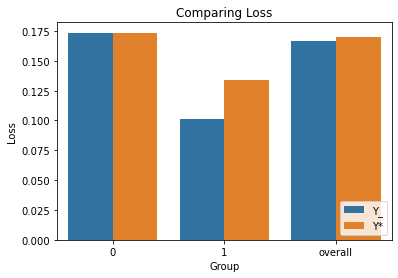

People with sex=Female account for 33.16% of the training data

Calibration: 

                              0         1
Fraction where Y_ = 1  0.261000  0.100600
Fraction where Y* = 1  0.261000  0.165400
Fraction where Y = 1   0.309985  0.110363



Loss: 

           0         1   overall
Y_  0.205194  0.087542  0.166564
Y*  0.205194  0.147026  0.186095




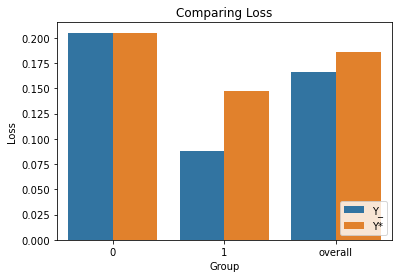

People with workclass=Private account for 69.75% of the training data

Calibration: 

                              0         1
Fraction where Y_ = 1  0.277500  0.178000
Fraction where Y* = 1  0.259800  0.233000
Fraction where Y = 1   0.284792  0.226775



Loss: 

           0         1   overall
Y_  0.203308  0.150477  0.166564
Y*  0.208955  0.189862  0.195676




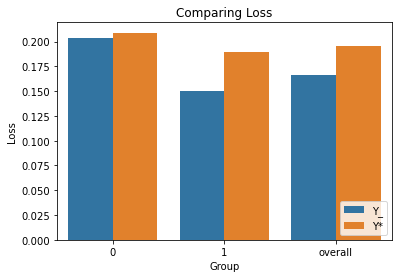

In [13]:
C_Y0 = []
C_Yhat0 = []
C_Ystar0 = []

C_Y1 = []
C_Yhat1 = []
C_Ystar1 = []

for attribute in zip(categories, targets):
    category = attribute[0]
    sensitive_attribute = attribute[1]

    frequency = sum(df_train[category + "_ " + sensitive_attribute])/len(df_train)
    print(f"People with {category}={sensitive_attribute} account for {frequency*100:.4}% of the training data")
    a = np.array(df_test[category + "_ " + sensitive_attribute])

    y_pred =  trained_model.predict(df_test.loc[:, df_train.columns != "output"])
    y_true = np.array(df_test["output"])

    # Fit balancer to adjust the predictions
    pb = BinaryBalancer(y=y_true, y_=y_pred, a=a, summary=False)
    pb.adjust(goal='odds', summary=False)

    calibration_table, _ = pb.summary(return_stats=True)
    
    # 0 is not the sensitive attrbibute
    C_Y0.append(calibration_table[0].loc["Fraction where Y = 1"])
    C_Yhat0.append(calibration_table[0].loc["Fraction where Y_ = 1"])
    C_Ystar0.append(calibration_table[0].loc["Fraction where Y* = 1"])
    
    # 1 is the sensitive attribute
    C_Y1.append(calibration_table[1].loc["Fraction where Y = 1"])
    C_Yhat1.append(calibration_table[1].loc["Fraction where Y_ = 1"])
    C_Ystar1.append(calibration_table[1].loc["Fraction where Y* = 1"])

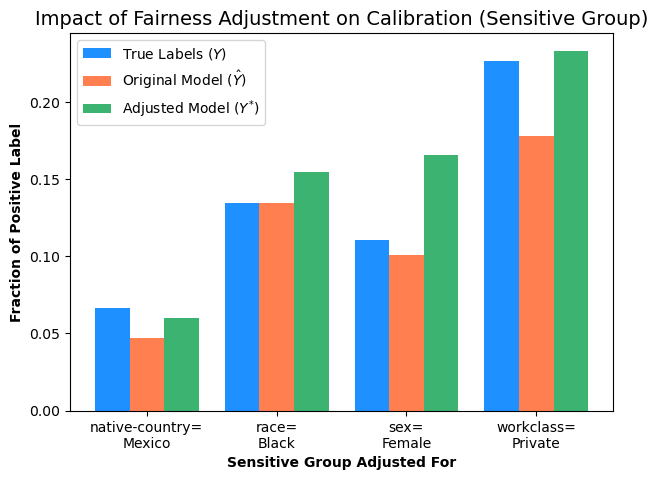

In [14]:
x = np.array([0, 1.5, 3, 4.5])
width = 0.4
label_font = {
    'color':  'k',
    'weight': 'heavy',
    'size': 10
}

title_font = {
    'color':  'k',
    'size': 14
}

attributes =[categories[i] + "=\n" + targets[i] for i in range(len(categories))]
plt.figure(figsize=(7,5), dpi=100)
plt.title("Impact of Fairness Adjustment on Calibration (Sensitive Group)", fontdict=title_font)
plt.bar(x - width,  C_Y1, width = width, color="dodgerblue")
plt.bar(x, C_Yhat1, width = width, color="coral")
plt.bar(x + width, C_Ystar1 ,width=width, color="mediumseagreen")

plt.xticks(x, attributes)
plt.xlabel("Sensitive Group Adjusted For", fontdict=label_font)
plt.ylabel("Fraction of Positive Label", fontdict=label_font)
plt.legend(["True Labels ($Y$)", "Original Model ($\hat{Y}$)", "Adjusted Model ($Y^{*}$)"], loc="upper left")
plt.savefig("Figures/calibration-sensitive.jpg")

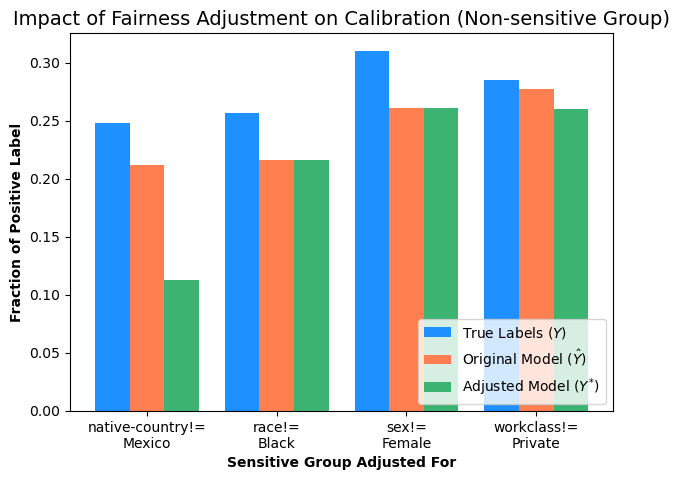

In [15]:
x = np.array([0, 1.5, 3, 4.5])
width = 0.4
label_font = {
    'color':  'k',
    'weight': 'heavy',
    'size': 10
}

title_font = {
    'color':  'k',
    'size': 14
}

attributes =[categories[i] + "!=\n" + targets[i] for i in range(len(categories))]
plt.figure(figsize=(7,5), dpi=100)
plt.title("Impact of Fairness Adjustment on Calibration (Non-sensitive Group)", fontdict=title_font)
plt.bar(x - width,  C_Y0, width = width, color="dodgerblue")
plt.bar(x, C_Yhat0, width = width, color="coral")
plt.bar(x + width, C_Ystar0 ,width=width, color="mediumseagreen")

plt.xticks(x, attributes)
plt.xlabel("Sensitive Group Adjusted For", fontdict=label_font)
plt.ylabel("Fraction of Positive Label", fontdict=label_font)
plt.legend(["True Labels ($Y$)", "Original Model ($\hat{Y}$)", "Adjusted Model ($Y^{*}$)"], loc="lower right")
plt.savefig("Figures/calibration-nonsensitive.jpg")

### Calibration vs Model Complexity

People with sex=Female account for 33.05% of the training data
Iteration 1, loss = 0.50494153
Iteration 2, loss = 0.42756525
Iteration 3, loss = 0.39454633
Iteration 4, loss = 0.37651423
Iteration 5, loss = 0.36566377
Iteration 6, loss = 0.35825428
Iteration 7, loss = 0.35226566
Iteration 8, loss = 0.34808865
Iteration 9, loss = 0.34441030
Iteration 10, loss = 0.34114339
Iteration 11, loss = 0.33883512
Iteration 12, loss = 0.33614370
Iteration 13, loss = 0.33417637
Iteration 14, loss = 0.33239357
Iteration 15, loss = 0.33073150
Iteration 16, loss = 0.32912479
Iteration 17, loss = 0.32769618
Iteration 18, loss = 0.32712242
Iteration 19, loss = 0.32535390
Iteration 20, loss = 0.32474081
Iteration 21, loss = 0.32350602
Iteration 22, loss = 0.32294919
Iteration 23, loss = 0.32214564
Iteration 24, loss = 0.32139007
Iteration 25, loss = 0.32115734
Iteration 26, loss = 0.32084625
Iteration 27, loss = 0.32021293
Iteration 28, loss = 0.32038367
Iteration 29, loss = 0.31940135
Iteration 30, loss

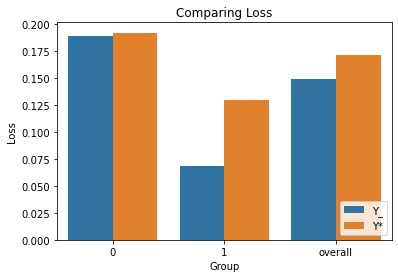

People with sex=Female account for 33.05% of the training data
Iteration 1, loss = 0.37922065
Iteration 2, loss = 0.34108276
Iteration 3, loss = 0.33199038
Iteration 4, loss = 0.32566855
Iteration 5, loss = 0.32037373
Iteration 6, loss = 0.31627916
Iteration 7, loss = 0.31272835
Iteration 8, loss = 0.31029566
Iteration 9, loss = 0.30869558
Iteration 10, loss = 0.30661099
Iteration 11, loss = 0.30511916
Iteration 12, loss = 0.30467973
Iteration 13, loss = 0.30156368
Iteration 14, loss = 0.30123670
Iteration 15, loss = 0.29921120
Iteration 16, loss = 0.29828646
Iteration 17, loss = 0.29800482
Iteration 18, loss = 0.29520512
Iteration 19, loss = 0.29459954
Iteration 20, loss = 0.29264938
Iteration 21, loss = 0.29299951
Iteration 22, loss = 0.29122772
Iteration 23, loss = 0.28949226
Iteration 24, loss = 0.28924389
Iteration 25, loss = 0.28890126
Iteration 26, loss = 0.28950388
Iteration 27, loss = 0.28721917
Iteration 28, loss = 0.28714655
Iteration 29, loss = 0.28502424
Iteration 30, loss

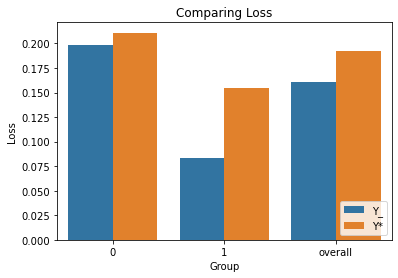

People with sex=Female account for 33.05% of the training data
Iteration 1, loss = 0.37557370
Iteration 2, loss = 0.33503000
Iteration 3, loss = 0.32328520
Iteration 4, loss = 0.31563490
Iteration 5, loss = 0.31134741
Iteration 6, loss = 0.30671511
Iteration 7, loss = 0.30191060
Iteration 8, loss = 0.29564915
Iteration 9, loss = 0.29440916
Iteration 10, loss = 0.28847092
Iteration 11, loss = 0.28450065
Iteration 12, loss = 0.28627417
Iteration 13, loss = 0.27899325
Iteration 14, loss = 0.27521356
Iteration 15, loss = 0.27308772
Iteration 16, loss = 0.26895696
Iteration 17, loss = 0.26667835
Iteration 18, loss = 0.26386978
Iteration 19, loss = 0.25863680
Iteration 20, loss = 0.25870132
Iteration 21, loss = 0.25745964
Iteration 22, loss = 0.26441493
Iteration 23, loss = 0.25435187
Iteration 24, loss = 0.25074789
Iteration 25, loss = 0.24591820
Iteration 26, loss = 0.24903496
Iteration 27, loss = 0.24317545
Iteration 28, loss = 0.24070734
Iteration 29, loss = 0.23941746
Iteration 30, loss

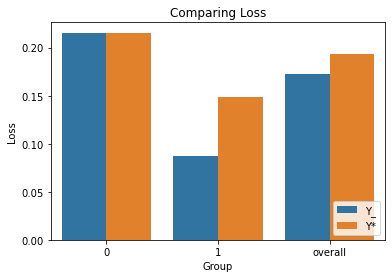

People with sex=Female account for 33.05% of the training data
Iteration 1, loss = 0.37233803
Iteration 2, loss = 0.33489870
Iteration 3, loss = 0.32279434
Iteration 4, loss = 0.31654638
Iteration 5, loss = 0.31339375
Iteration 6, loss = 0.30663955
Iteration 7, loss = 0.30247328
Iteration 8, loss = 0.29856202
Iteration 9, loss = 0.29446715
Iteration 10, loss = 0.28751694
Iteration 11, loss = 0.28380452
Iteration 12, loss = 0.28121192
Iteration 13, loss = 0.27727879
Iteration 14, loss = 0.27316977
Iteration 15, loss = 0.27370269
Iteration 16, loss = 0.26636330
Iteration 17, loss = 0.26213102
Iteration 18, loss = 0.26086547
Iteration 19, loss = 0.25784825
Iteration 20, loss = 0.25535342
Iteration 21, loss = 0.25294871
Iteration 22, loss = 0.24964995
Iteration 23, loss = 0.24863377
Iteration 24, loss = 0.24354677
Iteration 25, loss = 0.24200902
Iteration 26, loss = 0.25059218
Iteration 27, loss = 0.24065950
Iteration 28, loss = 0.23465858
Iteration 29, loss = 0.23352047
Iteration 30, loss

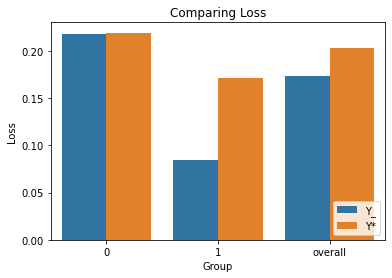

In [27]:
C_Y_MC = []
C_Yhat_MC = []
C_Ystar_MC = []

Y_acc_MC = []
Y_acc_adj_MC = []

category = "sex"
sensitive_attribute = "Female"

layer_sizes = [(1), (64), (128, 64, 32), (1024, 512, 256, 128, 64)]

for layers in layer_sizes:
    
    frequency = sum(df_train[category + "_ " + sensitive_attribute])/len(df_train)
    print(f"People with {category}={sensitive_attribute} account for {frequency*100:.4}% of the training data")
    a = np.array(df_test[category + "_ " + sensitive_attribute])
    
    
    new_model = MLPClassifier(hidden_layer_sizes=layers, 
                              learning_rate_init=.003, 
                              verbose=True, 
                              learning_rate="adaptive", 
                              max_iter=300)
    
    new_model = new_model.fit(df_train.loc[:, df_train.columns != "output"], df_train["output"])
    
    y_pred =  new_model.predict(df_test.loc[:, df_train.columns != "output"])
    y_true = np.array(df_test["output"])
    Y_acc_adj_MC.append(sum(y_true == y_pred)/len(y_true))
    
    # Fit balancer to adjust the predictions
    pb = BinaryBalancer(y=y_true, y_=y_pred, a=a, summary=False)
    pb.adjust(goal='odds', summary=False)

    calibration_table, _ = pb.summary(return_stats=True)
    
    Y_acc_adj_MC.append(sum(y_true == y_adj)/len(y_true))
    # 1 is the sensitive attribute
    C_Y_MC.append(calibration_table[1].loc["Fraction where Y = 1"])
    C_Yhat_MC.append(calibration_table[1].loc["Fraction where Y_ = 1"])
    C_Ystar_MC.append(calibration_table[1].loc["Fraction where Y* = 1"])

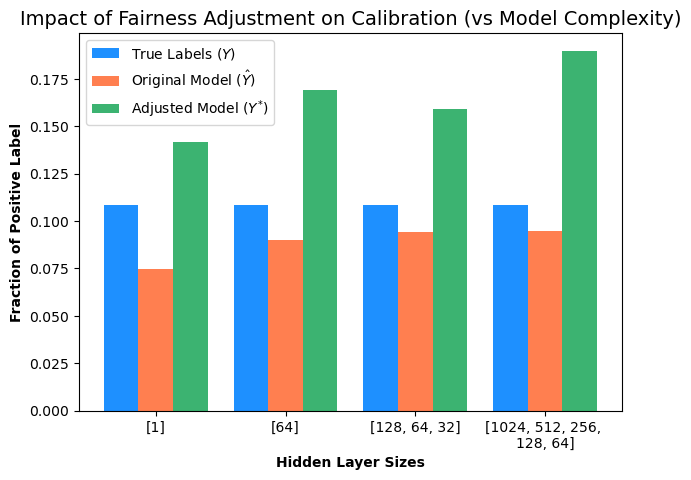

In [49]:
x = np.array([0, 1.5, 3, 4.5])
width = 0.4
label_font = {
    'color':  'k',
    'weight': 'heavy',
    'size': 10
}

title_font = {
    'color':  'k',
    'size': 14
}

plt.figure(figsize=(7,5), dpi=100)
plt.title("Impact of Fairness Adjustment on Calibration (vs Model Complexity)", fontdict=title_font)
# plot data in grouped manner of bar type
plt.bar(x - width,  C_Y_MC, width = width, color="dodgerblue")
plt.bar(x, C_Yhat_MC, width = width, color="coral")
plt.bar(x + width, C_Ystar_MC, width=width, color="mediumseagreen")

plt.xticks(x, ["[1]", "[64]", "[128, 64, 32]", "[1024, 512, 256, \n128, 64]"])
plt.xlabel("Hidden Layer Sizes", fontdict=label_font)
plt.ylabel("Fraction of Positive Label", fontdict=label_font)
plt.legend(["True Labels ($Y$)", "Original Model ($\hat{Y}$)", "Adjusted Model ($Y^{*}$)"], loc="upper left")
plt.savefig("Figures/calibration-nonsensitive-complexity.jpg")

In [41]:
Y_accs_on_group = []
Y_adj_accs_on_group = []
proportion_of_dataset = []
for attribute in zip(categories, targets):
    
    category = attribute[0]
    sensitive_attribute = attribute[1]
    frequency = sum(df_train[category + "_ " + sensitive_attribute])/len(df_train)
    proportion_of_dataset.append(frequency)
    print(f"People with {category}={sensitive_attribute} account for {frequency*100:.4}% of the training data")
    a = np.array(df_test[category + "_ " + sensitive_attribute])

    y_pred =  new_model.predict(df_test.loc[:, df_test.columns != "output"])
    y_true = np.array(df_test["output"])
    
    a_bool = a.astype(bool)

    group_acc = sum(y_pred[a_bool] == y_true[a_bool])/len(y_pred[a_bool])
    print(f"The model's loss on this group (0) is {1 - group_acc:.4}")
    Y_accs_on_group.append(group_acc)
    # Fit balancer to adjust the predictions
#     print("Before Adjustment\n", confusion_matrix(y_true[a_bool], y_pred[a_bool]), "\n-----")
    pb = BinaryBalancer(y=y_true, y_=y_pred, a=a, summary=False)
    pb.adjust(goal='odds', summary=False)
    y_adj = pb.get_adjusted_predictions()
    fair_group_acc = sum(y_adj[a_bool] == y_true[a_bool])/len(y_true[a_bool])
    Y_adj_accs_on_group.append(fair_group_acc)
#     print("After Adjustment\n", confusion_matrix(y_true[a_bool], y_adj[a_bool]), "\n-------")
    print(f"The model's loss on this group (0) after adjustment is {1 - fair_group_acc:.4}\n")

People with native-country=Mexico account for 1.937% of the training data
The model's loss on this group (0) is 0.05882
The model's loss on this group (0) after adjustment is 0.1059

People with race=Black account for 9.509% of the training data
The model's loss on this group (0) is 0.101
The model's loss on this group (0) after adjustment is 0.1446

People with sex=Female account for 33.05% of the training data
The model's loss on this group (0) is 0.08411
The model's loss on this group (0) after adjustment is 0.1678

People with workclass=Private account for 69.58% of the training data
The model's loss on this group (0) is 0.1564
The model's loss on this group (0) after adjustment is 0.1921



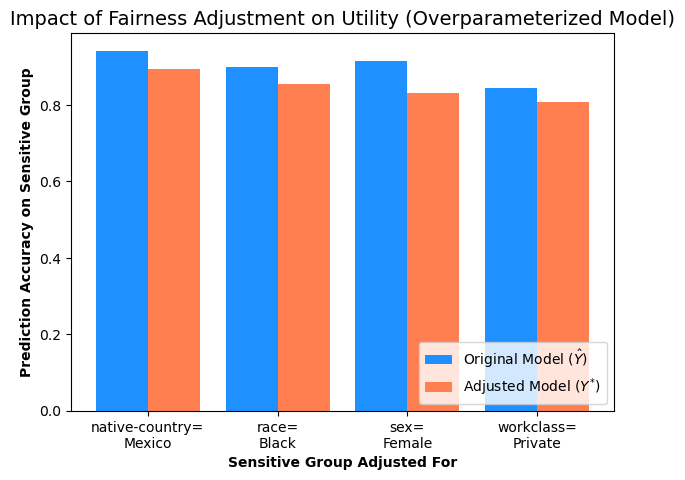

In [48]:
# create data
x = np.arange(len(categories))
width = 0.4
label_font = {
    'color':  'k',
    'weight': 'heavy',
    'size': 10
}

title_font = {
    'color':  'k',
    'size': 14
}

attributes =[categories[i] + "=\n" + targets[i] for i in range(len(categories))]
plt.figure(figsize=(7,5), dpi=100)
plt.title("Impact of Fairness Adjustment on Utility (Overparameterized Model)", fontdict=title_font)
# plot data in grouped manner of bar type
plt.bar(x - width,  Y_accs_on_group, width = width, color="dodgerblue")
plt.bar(x, Y_adj_accs_on_group, width = width, color="coral")

plt.xticks(x - width/2, attributes)
plt.xlabel("Sensitive Group Adjusted For", fontdict=label_font)
plt.ylabel("Prediction Accuracy on Sensitive Group", fontdict=label_font)
plt.legend(["Original Model ($\hat{Y}$)", "Adjusted Model ($Y^{*}$)"], loc="lower right")
# plt.savefig("Figures/subgroup_accuracy_overparameterized.jpg")

People with native-country=Mexico account for 1.937% of the training data
The model's overall accuracy is 82.66%
The model's overall accuracy after adjustment is 82.53%

People with race=Black account for 9.509% of the training data
The model's overall accuracy is 82.66%
The model's overall accuracy after adjustment is 82.18%

People with sex=Female account for 33.05% of the training data
The model's overall accuracy is 82.66%
The model's overall accuracy after adjustment is 79.74%

People with workclass=Private account for 69.58% of the training data
The model's overall accuracy is 82.66%
The model's overall accuracy after adjustment is 80.41%



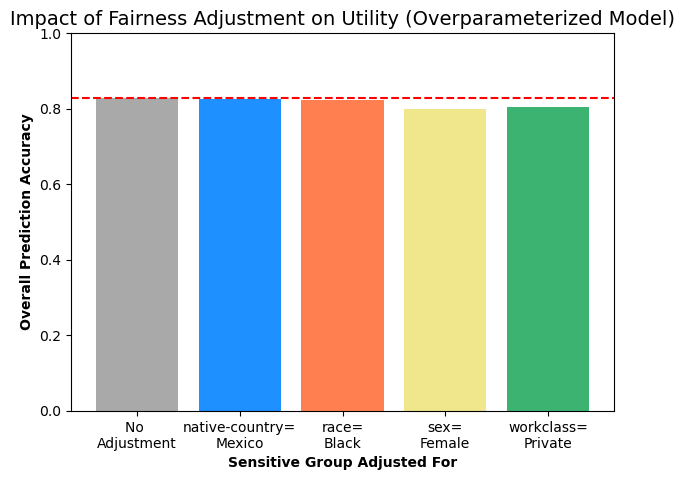

In [50]:
categories = ["native-country", "race", "sex", "workclass"]
targets = ["Mexico", "Black", "Female", "Private"]

Y_accs = []
Y_adj_accs = []
for attribute in zip(categories, targets):
    
    category = attribute[0]
    sensitive_attribute = attribute[1]
    
    
    
    frequency = sum(df_train[category + "_ " + sensitive_attribute])/len(df_train)
    print(f"People with {category}={sensitive_attribute} account for {frequency*100:.4}% of the training data")
    a = np.array(df_test[category + "_ " + sensitive_attribute])

    y_pred =  new_model.predict(df_test.loc[:, df_train.columns != "output"])
    y_true = np.array(df_test["output"])
    acc = sum(y_pred == y_true)/len(y_pred)
    print(f"The model's overall accuracy is {acc*100:.4}%")
    Y_accs.append(acc)
    
    # Fit balancer to adjust the predictions
    pb = BinaryBalancer(y=y_true, y_=y_pred, a=a, summary=False)
    pb.adjust(goal='odds', summary=False)
    fair_acc = sum(pb.get_adjusted_predictions() == y_true)/len(y_true)
    print(f"The model's overall accuracy after adjustment is {fair_acc*100:.4}%\n")
    Y_adj_accs.append(fair_acc)

    
x = np.arange(len(categories) + 1)
width = 0.4
label_font = {
    'color':  'k',
    'weight': 'heavy',
    'size': 10
}

title_font = {
    'color':  'k',
    'size': 14
}

attributes = ["No \nAdjustment"] + [categories[i] + "=\n" + targets[i] for i in range(len(categories))]
plt.figure(figsize=(7,5), dpi=100)
plt.title("Impact of Fairness Adjustment on Utility (Overparameterized Model)", fontdict=title_font)
plt.bar(x, [Y_accs[0]] + Y_adj_accs, color=["darkgrey", "dodgerblue", "coral", "khaki", "mediumseagreen"])

plt.xticks(x, attributes)
plt.xlabel("Sensitive Group Adjusted For", fontdict=label_font)
plt.ylabel("Overall Prediction Accuracy", fontdict=label_font)


plt.ylim(0,1)
ax = plt.gca()
ax.autoscale(False)
ax.plot(plt.gca().get_xlim(), [Y_accs[0], Y_accs[0]], c="r", linestyle="--")
plt.draw()
# plt.savefig("Figures/overall_accuracy_overparameterized.jpg")